In [1]:
# Modules

import numpy as np
import scipy.integrate as spint
import scipy.stats as spstat
import matplotlib.pyplot as plt
plt.rcParams['mathtext.fontset'] = 'stix'   

#import argparse

from joblib import Parallel, delayed

from dataclasses import dataclass

import os
os.environ['MKL_NUM_THREADS'] = '1'

In [2]:
# Class for the CANN model

class cann_model:
    # define the range of perferred stimuli
    z_min = - np.pi;              
    z_range = 2.0 * np.pi;
    # define the time scale
    tau = 2.0
        
    # function for periodic boundary condition
    def dist(self, c):
        tmp = np.remainder(c, self.z_range)
        
        # routine for numbers
        if isinstance(tmp, (int, float)):
            if tmp > (0.5 * self.z_range):
                return (tmp - self.z_range);
            return tmp;
        
        # routine for numpy arraies
        for tmp_1 in np.nditer(tmp, op_flags=['readwrite']):
            if tmp_1 > (0.5 * self.z_range):
                tmp_1[...] = tmp_1 - self.z_range;
        
        return tmp;
    
    # constructor (?)
    def __init__(self, argument):
        self.k = argument.k;              # rescaled inhibition
        self.beta = argument.beta;        # rescaled STD
        self.beta_f = argument.beta_f;    # flat STD ?
        self.case = argument.case
        self.taud = argument.taud;        # rescaled STD timescale
        self.a = argument.a;              # range of excitatory connection
        self.b = argument.b;              # range of beta modulation
        self.N = argument.N;              # number of units / neurons
        self.dx = self.z_range / self.N     # separation between neurons
        
        # define perferred stimuli for each neuron
        self.x = (np.arange(0,self.N,1)+0.5) * self.dx + self.z_min;
        
        # difference of x's
        self.x_diff = np.array(
                       [[self.dist(self.x[i] - self.x[j]) 
                         for j in range(self.x.shape[0])]
                        for i in range(self.x.shape[0])]
                       )
        
        # calculate the excitatory couple for each pair of neurons
        self.Jxx = np.exp(-0.5 * np.square(
                      self.x_diff / self.a
                   ) ) / (np.sqrt(2*np.pi) * self.a);
                
        self.y = np.zeros((self.N + self.N * self.N));   # initialize dynamical variables
        self.y[self.N:] = 1.0
        
        
        
        if self.beta_f:
            self.beta = argument.beta
        else:
            self.beta = np.zeros_like(self.x_diff)
            
            for i in np.arange(self.Jxx.shape[1]):
                if self.case > 0:
                    gamma_randm = np.random.gamma(shape=3.354520641938138, scale=9.743699331037247, size=self.Jxx.shape[0])
                else:
                    gamma_randm = np.random.gamma(shape=1.377771974410986, scale=29.196273404252505, size=self.Jxx.shape[0])
                    
                J_sort_idx = np.argsort(self.Jxx[:,i])
                gamma_sort_idx = np.argsort(gamma_randm)
                
                for j in np.arange(self.Jxx.shape[0]):
                    self.beta[J_sort_idx[j],i] = gamma_randm[gamma_sort_idx[j]]               
            
            self.beta *= argument.beta / np.mean(self.beta)
                             
                    
        # Here the first N y elements for u(x,t)
        # and the last N*N elements for p(x,x',t)
        
        self.r = np.zeros((self.N));                     # initialize neuronal activities
        self.input = np.zeros((self.N));                 # initialial the external input
    
    # function for setting external iput for each neuron
    def set_input(self, A, z0):
        self.input = \
        A * np.exp(-0.25 * np.square(self.dist(self.x - z0) / self.a));
    
    # function for calculation of neuronal activity of each neuron
    def cal_r_or_u(self, u_in):
        
        if (u_in.shape[0] > self.N):
            u = u_in[:self.N]
        else:
            u = u_in
            
        u0 = 0.5 * (u + np.abs(u));
        r = np.square(u0);
        B = 1.0 + 0.125 * self.k * np.sum(r) * self.dx \
        / (np.sqrt(2*np.pi) * self.a);
        r = r / B;
        
        return r;
    
    # Calculate the centre of mass of u(x,t)
    def cm_of_u(self):
        u = self.y[:self.N]
        max_i = u.argmax()
        cm = np.dot(self.dist(self.x - self.x[max_i]), u) / u.sum()
        cm = cm + self.x[max_i]
        return cm;
    
    # function for calculation of derivatives
    def get_dydt(self, t, y):
        u = y[:self.N]
        p = y[self.N:].reshape((self.N, self.N))
        r = self.cal_r_or_u(u)
        
        dudt = \
            -u + np.dot(self.Jxx* p , r) * self.dx + self.input;
        dudt = dudt / self.tau;
        
        dpdt = (1-p - self.beta * p * r) / self.taud
        
        dydt = np.append(dudt, dpdt.reshape(-1))
        
        return dydt
    
    
    
    # function for calculation of derivatives
    def get_dydt_sym(self, t, y):
        u = y[:self.N]
        p = y[self.N:].reshape((self.N, self.N))
        r = self.cal_r_or_u(u)
        
        dudt = \
            -u + np.dot(self.Jxx* p , r) * self.dx + self.input;
        dudt = dudt / self.tau;

        dudt = 0.5 * (dudt + dudt[::-1])
        
        dpdt = (1-p - self.beta * p * r) / self.taud
        
        dydt = np.append(dudt, dpdt.reshape(-1))
        
        return dydt

In [3]:
# Defining a class of input arguments as a workaround 
# for the argparse

@dataclass()
class argument_c:
    k:float
    beta:float
    beta_f:bool
    case:int
    taud:float
    a:float
    b:float
    N:int
    
    def _init__(self, N, k, beta, beta_f, case, taud, a, b):
        self.N = N
        self.k = k
        self.beta = beta
        self.case = case
        self.beta_f = beta_f
        self.taud = taud
        self.a = a
        self.b = b

In [4]:
    
all_data = []
all_k = []

k_in = 0.5
beta_in = 0.00003
seed_in = 100

def one_round(k_in, beta_in, seed_in):
    
    print(beta_in)

    np.random.seed(seed_in)

    the_beta = beta_in

    arg1 = argument_c(N=128, k=k_in, beta=the_beta, beta_f=False, case=0, taud=100, a=0.5, b=None)
    the_model1 = cann_model(arg1)

    arg2 = argument_c(N=128, k=k_in, beta=the_beta, beta_f=False, case=1, taud=100, a=0.5, b=None)
    the_model2 = cann_model(arg2)

    # Initialize the system

    the_model1.set_input(np.sqrt(8.0)/k_in, 0)

    the_model1.y[0:the_model1.N] = the_model1.input            
    the_model2.y[0:the_model2.N] = the_model1.input            

    the_model1.set_input(0, 0)
    the_model2.set_input(0, 0)

    out1 = spint.solve_ivp(the_model1.get_dydt_sym, (0, 1000), the_model1.y, method="RK45");
    out2 = spint.solve_ivp(the_model2.get_dydt_sym, (0, 1000), the_model2.y, method="RK45");

    # update the network state in the CANN object
    the_model1.y = out1.y[:,-1]
    the_model2.y = out2.y[:,-1]

    N = the_model1.N
    N_shift = N-int(0.67 * N * the_model1.a / (the_model1.x.max() - the_model2.x.min()))
    y_tmp = the_model1.y[0:N]
    the_model1.y[0:N] = np.append(y_tmp[N_shift:], y_tmp[:N_shift] )

    # plt.plot(the_model1.y[0:N])
    # plt.show()

    # return 0

    N = the_model2.N
    N_shift =N - int(0.67 * N * the_model2.a / (the_model2.x.max() - the_model2.x.min()))
    y_tmp = the_model2.y[0:N]
    the_model2.y[0:N] =  np.append(y_tmp[N_shift:], y_tmp[:N_shift] )

    out1 = spint.solve_ivp(the_model1.get_dydt, (0, 20000), the_model1.y, method="RK45");
    out2 = spint.solve_ivp(the_model2.get_dydt, (0, 20000), the_model2.y, method="RK45");

    # update the network state in the CANN object
    the_model1.y = out1.y[:,-1]
    the_model2.y = out2.y[:,-1]

    time_step = 1

    # take a initial snapshot
    snapshots1_z = []
    snapshots2_z = []

    # Sample duration
    t_max = 10000

    # 
    to2snap = False
    z_last = 0

    # run the simulation and take snapshots every 10 taus
    for t in range(0, t_max, time_step):
        # decide the period of this step
        t0 = t
        t1 = t + time_step
        # run the simulation and update the state in the CANN object
        out1 = spint.solve_ivp(the_model1.get_dydt, (t0, t1), the_model1.y, method="RK45")
        the_model1.y = out1.y[:,-1]
        out2 = spint.solve_ivp(the_model2.get_dydt, (t0, t1), the_model2.y, method="RK45")
        the_model2.y = out2.y[:,-1]
        if len(snapshots1_z) < 1:
            snapshots1_z.append(the_model1.cm_of_u())
            snapshots2_z.append(the_model2.cm_of_u())
        else:
            snapshots1_z.append(snapshots1_z[-1]+the_model1.dist(the_model1.cm_of_u()-snapshots1_z[-1]))
            snapshots2_z.append(snapshots2_z[-1]+the_model2.dist(the_model2.cm_of_u()-snapshots2_z[-1]))

        if np.abs(snapshots1_z[-1] - snapshots1_z[0]) > 1.0 and len(snapshots1_z) > 2:
            if np.abs(the_model1.cm_of_u()) < the_model1.dx / 0.5 and the_model1.cm_of_u() * z_last <= 0:
                return the_model1.x, the_model1.y[:the_model1.N], the_model1.y[the_model1.N:].reshape((the_model1.N, the_model1.N))

        z_last = the_model1.cm_of_u()

        # print(the_model1.cm_of_u())
            

    return v_out1, v_out2 

y_sample = one_round(k_in = 0.5, beta_in = 0.005, seed_in = 1)


0.005


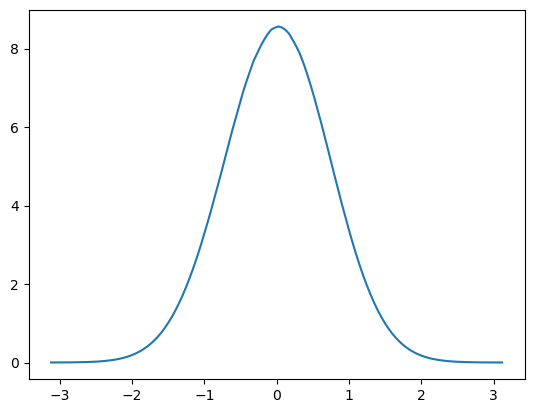

In [5]:
plt.plot(y_sample[0], y_sample[1])

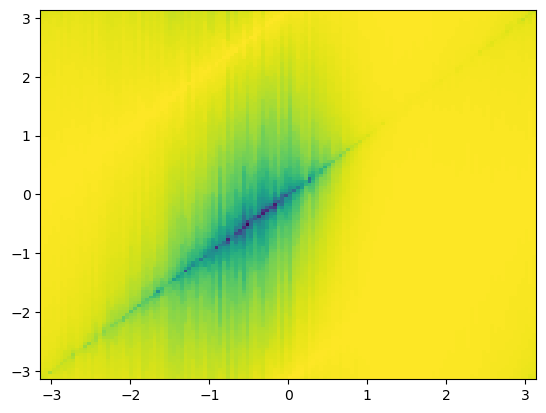

In [6]:
plt.pcolormesh(y_sample[0],y_sample[0], y_sample[2])

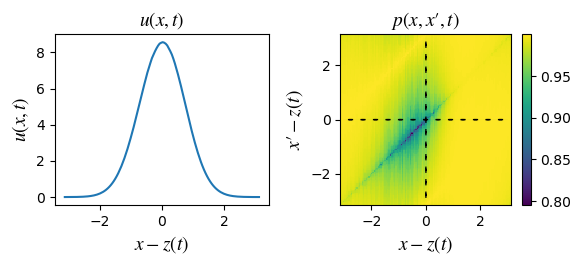

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(15/2.525, 7/2.525))


axs[0].plot(y_sample[0], y_sample[1])

color1 = axs[1].pcolormesh(y_sample[0],y_sample[0], y_sample[2])

plt.colorbar(color1)

for ax in axs:
    ax.set_xlabel(r'$x-z(t)$', fontsize=14)

axs[0].set_ylabel(r'$u(x,t)$', fontsize=14)
axs[1].set_ylabel(r'$x\prime-z(t)$', fontsize=14)

#axs[0].set_title("(A)", loc="left", x=-0.1)
#axs[1].set_title("(B)", loc="left", x=-0.1)

axs[0].text(0.5,1.05,"$u(x,t)$",transform=axs[0].transAxes, ha='center', fontsize=14)
axs[1].text(0.5,1.05,"$p(x,x\prime,t)$",transform=axs[1].transAxes, ha='center', fontsize=14)

axs[1].arrow(0,-3,0,6, linestyle=(5, (3,6)))
axs[1].arrow(-3,0,6,0, linestyle=(5, (3,6)))

plt.tight_layout()

plt.savefig("Figure_04AB.pdf")